In [18]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import datasets, image, plotting
from nilearn.maskers import NiftiLabelsMasker
import nibabel as nb

from nltools.mask import expand_mask, roi_to_brain
from nltools.data import Brain_Data
from nilearn.plotting import plot_glass_brain, plot_img_on_surf, plot_roi
from nltools.stats import fdr

# ignore warnings - if you want to reset, run warnings.resetwarnings()
import warnings
warnings.simplefilter('ignore',UserWarning)

In [2]:
# initialize subject_list and path lists
num_of_subjects = 10 
excluded = [7,8]
subject_list = ["{:02d}".format(i) for i in range(1,num_of_subjects+1) if i not in excluded]
normdiff_file_list=[]; face_file_list=[]; general_file_list=[];
# data 
data_dir = '/home/anakin/Desktop/ds000113/output/2nd_level'
for sub in subject_list:
    normdiff_file_list.append(os.path.join(data_dir,sub,'fixed_effects',sub,f'_fixed_eff_model9','zstat1.nii.gz')) # normdiff > rms
    face_file_list.append(os.path.join(data_dir,sub,'fixed_effects',sub,f'_fixed_eff_model11','zstat1.nii.gz')) # face > speech
    general_file_list.append(os.path.join(data_dir,sub,'fixed_effects',sub,f'_fixed_eff_model13','zstat1.nii.gz')) # general > other

#conditions = ['Gaze','Touch','Affect','General']

In [3]:
# outputs
output_dir = os.path.join(os.getcwd(),"ROI_analysis")
try:    
    os.makedirs(output_dir)
except:
    pass

In [4]:
# we will fetch the bilateral harvard oxford atlas
harOxC_atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")

# set up NiftiLabelsMasker to extract volume values from multiple ROIs (the AAL atlas)
harOxC_masker = NiftiLabelsMasker(labels_img=harOxC_atlas.maps)

# define an empty list to store volume values for each participant
normdiff_data = []; face_data=[]; general_sync_data=[];

# loop over participants, respectively extract and storing volume values
for i,data_img in enumerate(general_file_list):
    
    # load the current image using nibabel
    general_img = nb.load(data_img)
    normdiff_img = nb.load(normdiff_file_list[i])
    face_img = nb.load(face_file_list[i])
    
    # extract volume value per ROI from current image and append it to the list
    general_sync_data.append(harOxC_masker.fit_transform(general_img).squeeze())
    normdiff_data.append(harOxC_masker.fit_transform(normdiff_img).squeeze())
    face_data.append(harOxC_masker.fit_transform(face_img).squeeze())

# convert the list into a pandas DataFrame, assigning atlas labels as columns
df_general_sync_data_HOc = pd.DataFrame(general_sync_data, columns=harOxC_atlas.labels[1:])
df_normdiff_data_HOc = pd.DataFrame(normdiff_data, columns=harOxC_atlas.labels[1:])
df_face_data_HOc = pd.DataFrame(face_data, columns=harOxC_atlas.labels[1:])

In [5]:
# name all columns of Harvard Oxford Cortical
for i in df_general_sync_data_HOc.columns:
    print(i)

Frontal Pole
Insular Cortex
Superior Frontal Gyrus
Middle Frontal Gyrus
Inferior Frontal Gyrus, pars triangularis
Inferior Frontal Gyrus, pars opercularis
Precentral Gyrus
Temporal Pole
Superior Temporal Gyrus, anterior division
Superior Temporal Gyrus, posterior division
Middle Temporal Gyrus, anterior division
Middle Temporal Gyrus, posterior division
Middle Temporal Gyrus, temporooccipital part
Inferior Temporal Gyrus, anterior division
Inferior Temporal Gyrus, posterior division
Inferior Temporal Gyrus, temporooccipital part
Postcentral Gyrus
Superior Parietal Lobule
Supramarginal Gyrus, anterior division
Supramarginal Gyrus, posterior division
Angular Gyrus
Lateral Occipital Cortex, superior division
Lateral Occipital Cortex, inferior division
Intracalcarine Cortex
Frontal Medial Cortex
Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)
Subcallosal Cortex
Paracingulate Gyrus
Cingulate Gyrus, anterior division
Cingulate Gyrus, posterior division
Precuneous Cortex
C

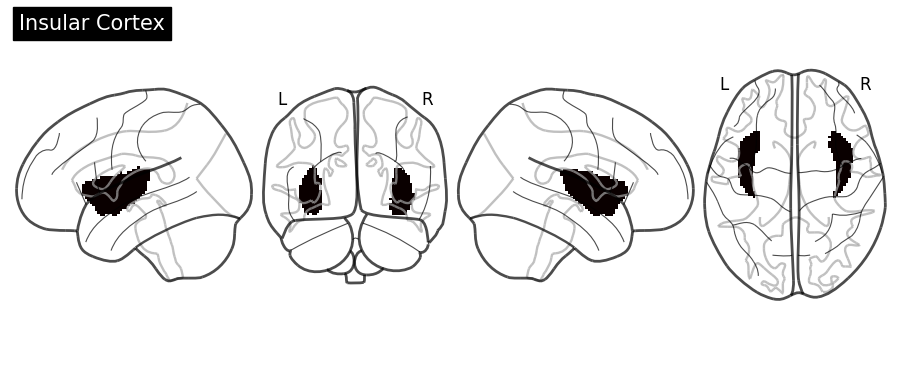

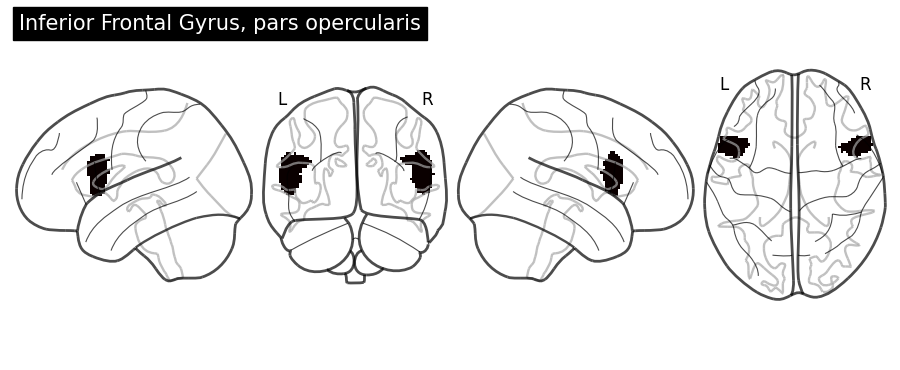

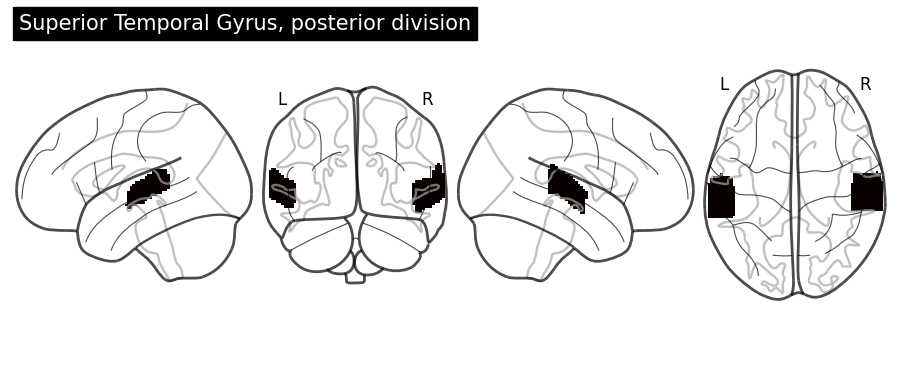

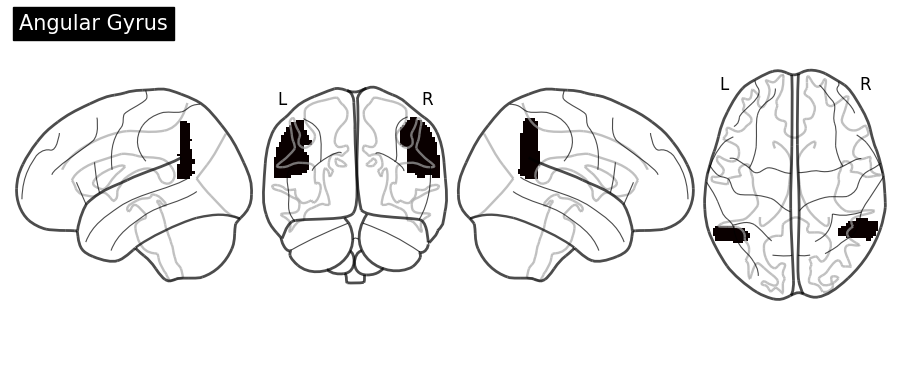

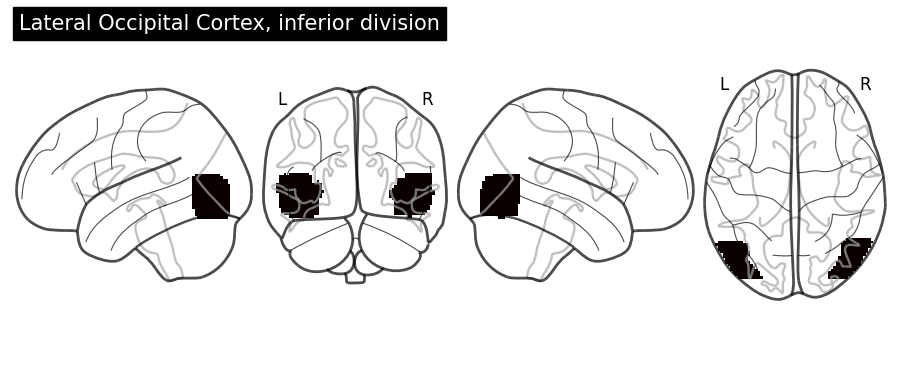

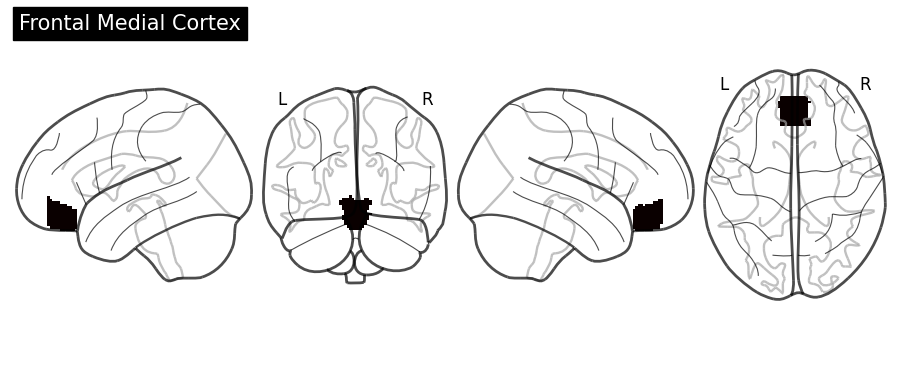

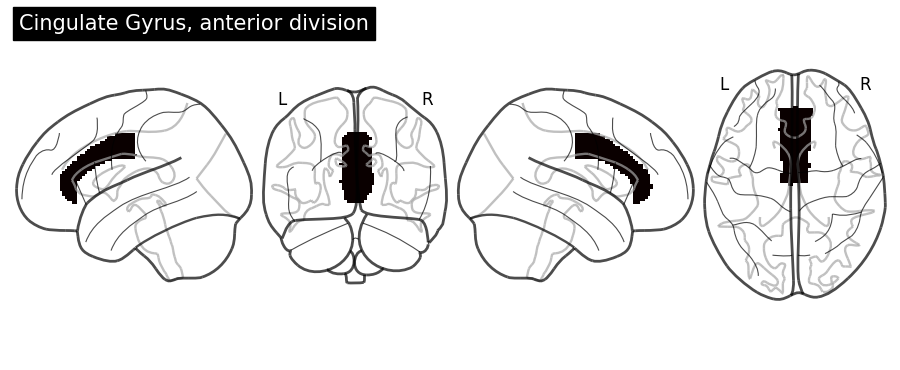

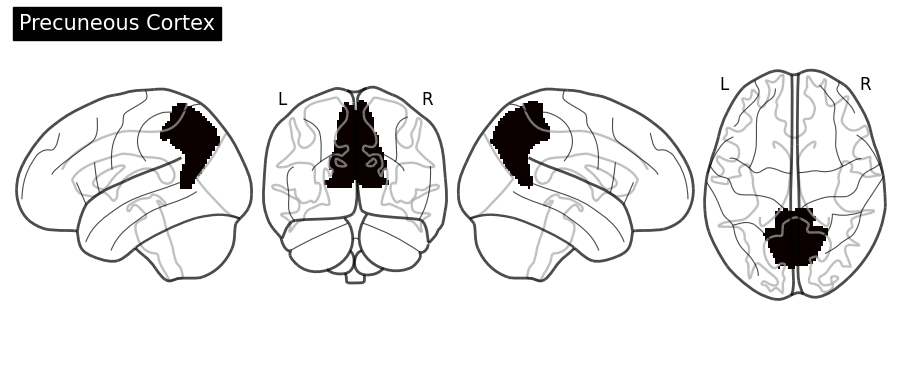

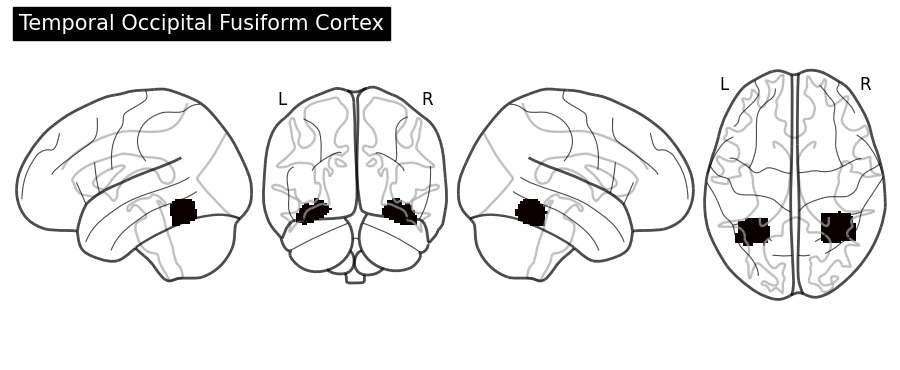

In [6]:
# create an ROI list

harv_mask = Brain_Data(r'data/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz')
harv_mask_x = expand_mask(harv_mask)
ROI_list = [1,5,9,20,22,24,28,30,38] # social ROIs
ROI_names = ['Insular Cortex',
             'Inferior Frontal Gyrus, pars opercularis',
             'Superior Temporal Gyrus, posterior division',
             'Angular Gyrus',
             'Lateral Occipital Cortex, inferior division',
             'Frontal Medial Cortex',
             'Cingulate Gyrus, anterior division',
             'Precuneous Cortex',
             'Temporal Occipital Fusiform Cortex']
# plot an example all ROIs
for roi,name in zip(ROI_list,ROI_names):
    plot_glass_brain(harv_mask_x[roi].to_nifti(),display_mode="lyrz",title=name)
# other views are:
# ['l', 'lr', 'lyr', 'lyrz', 'lzr', 'lzry', 'ortho', 'r', 'x', 'xz', 'y', 'yx', 'yz', 'z']

In [7]:
# create a dataframe of selected ROIs for each condition 

# general>other (sync)
general_roi_df = df_general_sync_data_HOc[ROI_names].copy()

roi_names = ['Prec','ACC','FMC','Occ_Fusi','inf_LOC','inf_FG','pSTG','Insula','Angular']

Text(0.5, 1.0, 'General vs Other synchrony ROI analysis')

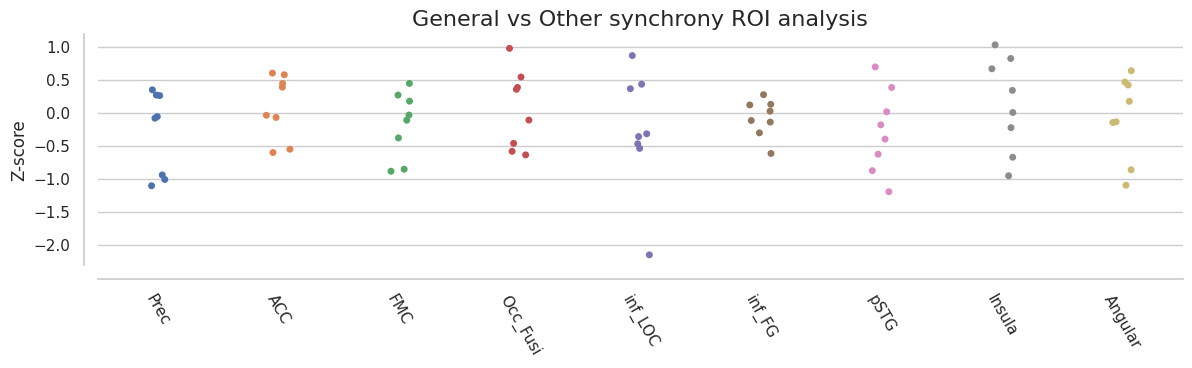

In [8]:
# for starters lets look how all data points look like.
# it's ugly, but is only for eyeballing

# set figure parameters
sns.set(rc={"figure.figsize":(14,3)}) 
sns.set_style('whitegrid')

# create plot
g = sns.stripplot(general_roi_df)

# set some aesthetics 
sns.despine(offset=10)

# rotate labels for readability
g.set_xticklabels(labels=roi_names, rotation=-60);

# assign axis labels
g.set_ylabel('Z-score');
g.set_title('General vs Other synchrony ROI analysis',size=16)

(-3.0, 3.0)

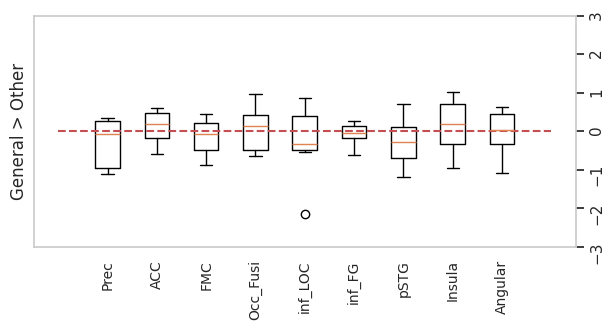

In [9]:
plt.figure(figsize=(7, 3)) 
plt.boxplot(general_roi_df.transpose().T)
plt.grid(None)
plt.xticks(np.arange(len(roi_names))+1,roi_names, rotation=90,size=10)
#plt.title('Gaze', size=12)
#plt.xticks([], [])
plt.hlines(0,0,len(ROI_names)+1,color='r',linestyles='dashed')
ax = plt.gca()
ax.yaxis.tick_right()
plt.yticks(rotation=90)
plt.ylabel('General > Other')
plt.ylim(-3,3)

# save figure
#plt.savefig(os.path.join(output_dir,"ROI_Zscore_General_vs_Other.png"))

In [10]:
def t_test_dataframe(dataframe,nROIs):
    """
    a function to preform a one sample t-test for a dataframe 
    """
    # imports
    import pandas as pd
    import numpy as np
    from scipy import stats
    # initilize result list
    result_data = []
    # loop over eace ROI 
    for column in dataframe.columns:
        values = dataframe[column]
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        t_stat, p_value = stats.ttest_1samp(values, popmean=0,alternative='greater')
        confidence_interval = stats.t.interval(0.95, df=n-1, loc=mean, scale=std/np.sqrt(n))
        # p < 0.05 - uncorrected
        if p_value < 0.05:
            passed = 1
        else:
            passed = 0
        # bonferroni
        if p_value < 0.05/nROIs:
            bonf = 1
        else:
            bonf = 0
            
        result_data.append({
            'ROI Name': column,
            'Mean': mean,
            'T-Stat': t_stat,
            'P-Value': p_value,
            'Confidence_Interval': confidence_interval,
            'p < 0.05': passed,
            'Bonferroni': bonf
        })

    result_dataframe = pd.DataFrame(result_data)
    result_dataframe['Confidence_Interval'] = result_dataframe['Confidence_Interval'].apply(lambda x: np.round(x,3))
    
    return result_dataframe

In [11]:
general_ttest = t_test_dataframe(general_roi_df,len(ROI_names))
general_ttest.style.hide(axis="index").set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')] )])

ROI Name,Mean,T-Stat,P-Value,Confidence_Interval,p < 0.05,Bonferroni
Insular Cortex,-0.287800,-1.305420,0.883492,[-0.809 0.234],0,0
"Inferior Frontal Gyrus, pars opercularis",0.095266,0.556329,0.297657,[-0.31 0.5 ],0,0
"Superior Temporal Gyrus, posterior division",-0.170228,-0.967319,0.817196,[-0.586 0.246],0,0
Angular Gyrus,0.059757,0.284901,0.391982,[-0.436 0.556],0,0
"Lateral Occipital Cortex, inferior division",-0.269692,-0.835015,0.784359,[-1.033 0.494],0,0
Frontal Medial Cortex,-0.076963,-0.768959,0.766468,[-0.314 0.16 ],0,0
"Cingulate Gyrus, anterior division",-0.271206,-1.210189,0.867259,[-0.801 0.259],0,0
Precuneous Cortex,0.128023,0.506664,0.313978,[-0.469 0.726],0,0
Temporal Occipital Fusiform Cortex,-0.066509,-0.298624,0.613051,[-0.593 0.46 ],0,0


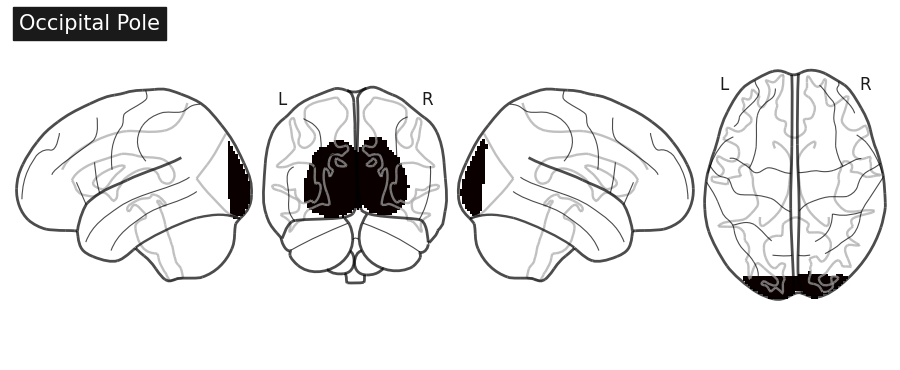

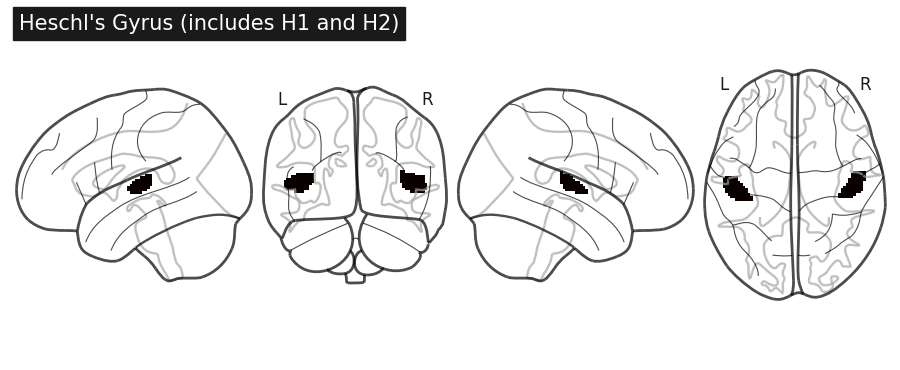

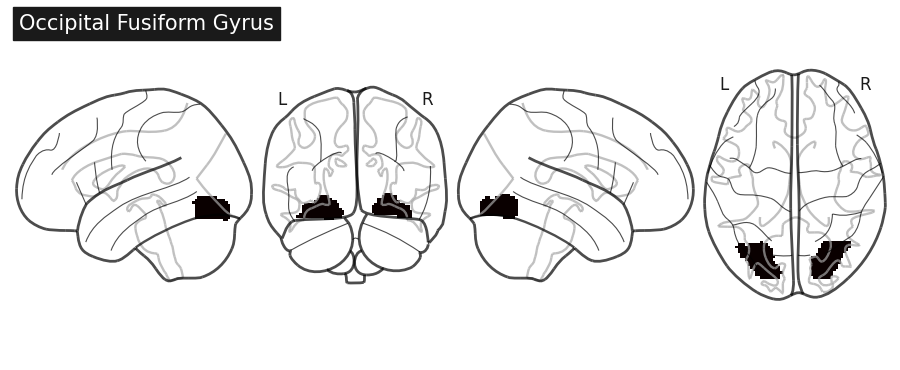

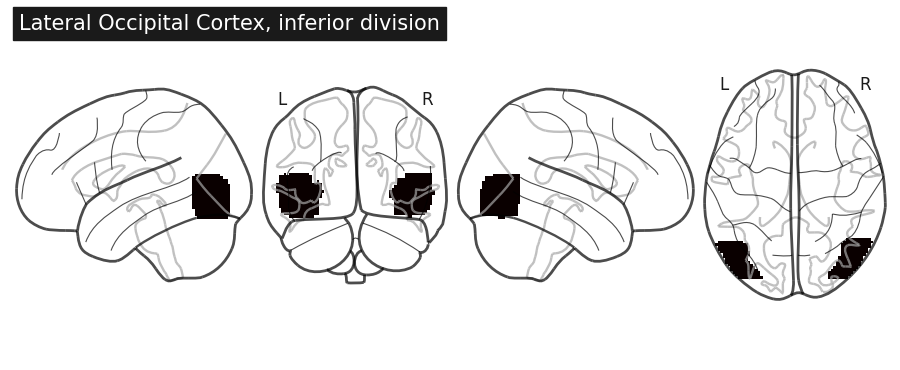

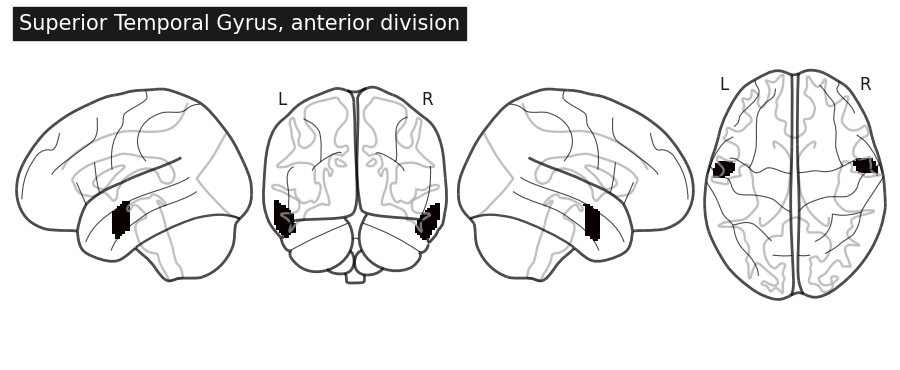

In [12]:
# lets try the visual contrast using both visual and auditory ROIs

ROI_list = [47,44,39,22,10] # audiovisual
ROI_names = ['Occipital Pole',
             r"Heschl's Gyrus (includes H1 and H2)",
             'Occipital Fusiform Gyrus',
             'Lateral Occipital Cortex, inferior division',
             'Superior Temporal Gyrus, anterior division']

normdiff_roi_df = df_normdiff_data_HOc[ROI_names].copy()


roi_names = ['occ_cortex','A1','OCC_Fusi','inf_LOC','aSTG']

# plot  all ROIs
for roi,name in zip(ROI_list,ROI_names):
    plot_glass_brain(harv_mask_x[roi].to_nifti(),display_mode="lyrz",title=name)

(-6.5, 6.5)

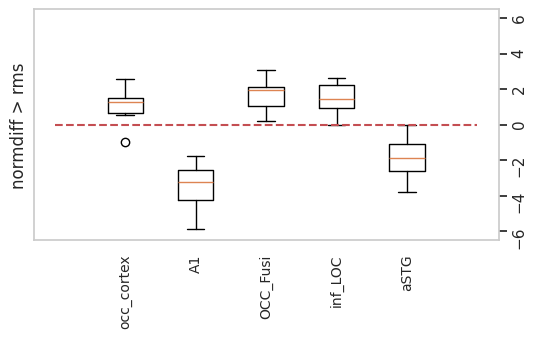

In [13]:
plt.figure(figsize=(6, 3)) 
plt.boxplot(normdiff_roi_df.transpose().T)
plt.grid(None)
plt.xticks(np.arange(len(roi_names))+1,roi_names, rotation=90,size=10)
plt.hlines(0,0,len(roi_names)+1,color='r',linestyles='dashed')
ax = plt.gca()
ax.yaxis.tick_right()
plt.yticks(rotation=90)
plt.ylabel('normdiff > rms')
plt.ylim(-6.5,6.5)

# save figure
#plt.savefig(os.path.join(output_dir,"ROI_Zscore_gaze.png"))

In [14]:
# notice that we are testing the normdiff > rms contrast and we conduct a one sample t-test (greater than 0)
# because of that we can see that although A1 and aSTG are clearly significant for audio, the stat table will 
# not state that it is. you can either change the alternative hypotesis within the 't_test_dataframe' function
# or load the rms > normdiff contrast.

normdiff_ttest = t_test_dataframe(normdiff_roi_df,len(ROI_names))
normdiff_ttest.style.hide(axis="index").set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')] )])

ROI Name,Mean,T-Stat,P-Value,Confidence_Interval,p < 0.05,Bonferroni
Occipital Pole,1.066880,2.890592,0.011648,[0.194 1.94 ],1,0
Heschl's Gyrus (includes H1 and H2),-3.493353,-7.049973,0.999899,[-4.665 -2.322],0,0
Occipital Fusiform Gyrus,1.680982,4.838538,0.000940,[0.859 2.502],1,1
"Lateral Occipital Cortex, inferior division",1.424625,4.037869,0.002473,[0.59 2.259],1,1
"Superior Temporal Gyrus, anterior division",-1.885976,-4.465174,0.998541,[-2.885 -0.887],0,0


In [15]:
# lets color some ROIs based on our t-test 
# for that i made 5 mask files with audiovisual ROIs, let's load them
masks_folder = r"data/av_ROIs"
masks =  glob.glob(os.path.join(masks_folder,'*'))
# use the order of the list in the next box
masks

['data/av_ROIs/Occipital_Pole.nii.gz',
 'data/av_ROIs/Heschls_Gyrus.nii.gz',
 'data/av_ROIs/inf_Lateral_Occipital_Cortex.nii.gz',
 'data/av_ROIs/Occipital_Fusiform_Gyrus.nii.gz',
 'data/av_ROIs/ant_Superior_Temporal_Gyrus.nii.gz']

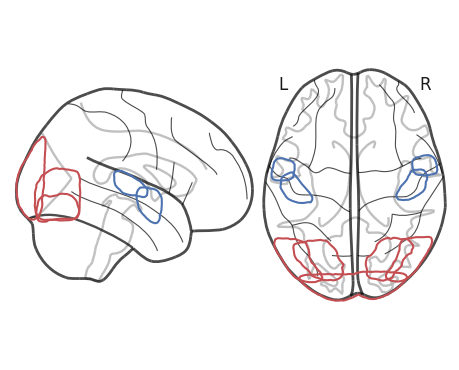

In [16]:
# glass brain
display = plot_glass_brain(None, display_mode="xz") # empty template

# color each mask with contours, we will use red and blue in the same manner as our ttest (red is visual)
display.add_contours(masks[0],colors=["r"],levels=[20, 100],filled=False) # Occipital_Pole
display.add_contours(masks[1],colors=["b"],levels=[20, 100],filled=False) # Heschls_Gyrus
display.add_contours(masks[2],colors=["r"],levels=[20, 100],filled=False) # inf_Lateral_Occipital_Cortex
display.add_contours(masks[3],colors=["r"],levels=[20, 100],filled=False) # Occipital_Fusiform_Gyrus
display.add_contours(masks[4],colors=["b"],levels=[20, 100],filled=False) # ant_Superior_Temporal_Gyrus
# save figure
display.savefig(output_dir+'/av_ROIs_glass.png',dpi=900)
#display.close()

In [17]:
def fdr_BH(p_vals):
    """ 
    a function to calculate fdr (BH)
    """
    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return np.array(fdr)